In [4]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
import tensorflow.examples.tutorials.mnist.input_data as input_data
import matplotlib.pyplot as plt

In [5]:
def corrupt(x):
    return tf.mul(x, tf.cast(tf.random_uniform(shape=tf.shape(x), minval=0, maxval=2,
                                               dtype=tf.int32), tf.float32))

def autoencoder(dimensions=[784, 512, 256, 64]):

    # input to the network
    x = tf.placeholder(tf.float32, [None, dimensions[0]], name='x')

    corrupt_prob = tf.placeholder(tf.float32, [1])
    current_input = corrupt(x) * corrupt_prob + x * (1 - corrupt_prob)

    # Build the encoder
    encoder = []
    for layer_i, n_output in enumerate(dimensions[1:]):
        n_input = int(current_input.get_shape()[1])
        W = tf.Variable(
            tf.random_uniform([n_input, n_output],
                              -1.0 / math.sqrt(n_input),
                              1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = tf.nn.tanh(tf.matmul(current_input, W) + b)
        current_input = output
    # latent representation
    z = current_input
    encoder.reverse()
    # Build the decoder using the same weights
    for layer_i, n_output in enumerate(dimensions[:-1][::-1]):
        W = tf.transpose(encoder[layer_i])
        b = tf.Variable(tf.zeros([n_output]))
        output = tf.nn.tanh(tf.matmul(current_input, W) + b)
        current_input = output
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.sqrt(tf.reduce_mean(tf.square(y - x)))
    return {'x': x, 'z': z, 'y': y,
            'corrupt_prob': corrupt_prob,
            'cost': cost}

In [8]:
# load MNIST as before
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mean_img = np.mean(mnist.train.images, axis=0)
ae = autoencoder(dimensions=[784, 256, 64])

# %%
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# %%
# Fit all training data
batch_size = 64
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        train = np.array([img - mean_img for img in batch_xs])
        sess.run(optimizer, feed_dict={
            ae['x']: train, ae['corrupt_prob']: [1.0]})
    print("Epoch :", epoch_i+1, ",  Cost :", sess.run(ae['cost'], 
                                                      feed_dict={ae['x']: train, ae['corrupt_prob']: [1.0]}))

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Epoch : 1 ,  Cost : 0.145068
Epoch : 2 ,  Cost : 0.132384
Epoch : 3 ,  Cost : 0.125977
Epoch : 4 ,  Cost : 0.126425
Epoch : 5 ,  Cost : 0.128948
Epoch : 6 ,  Cost : 0.129555
Epoch : 7 ,  Cost : 0.12771
Epoch : 8 ,  Cost : 0.125739
Epoch : 9 ,  Cost : 0.127059
Epoch : 10 ,  Cost : 0.124537


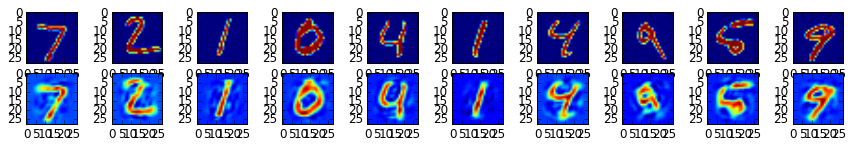

In [10]:
# Plot example reconstructions
n_examples = 10
test_xs, _ = mnist.test.next_batch(n_examples)
test_xs_norm = np.array([img - mean_img for img in test_xs])
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm, ae['corrupt_prob']: [1.0]})
fig, axs = plt.subplots(2, n_examples, figsize=(15, 2))
for example_i in range(n_examples):
    axs[0][example_i].imshow(
        np.reshape(test_xs[example_i, :], (28, 28)))
    axs[1][example_i].imshow(
        np.reshape([recon[example_i, :] + mean_img], (28, 28)))
plt.draw()

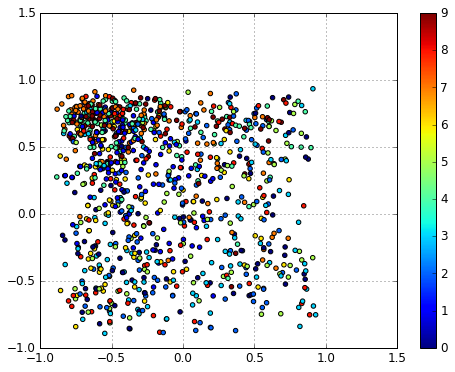

In [12]:
n_examples = 1000
test_xs, test_ys = mnist.test.next_batch(n_examples)
test_xs_norm = np.array([img - mean_img for img in test_xs])
z = sess.run(ae['z'], feed_dict={ae['x']: test_xs_norm, ae['corrupt_prob']: [1.0]})
plt.figure(figsize=(8, 6)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(test_ys, 1))
plt.colorbar()
plt.grid()